# Rain Prediction without Feature Scaling
---

# Importing the libraries

In [2]:
# !pip install xgboost

In [3]:
# !pip install catboost

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

# Data preprocessing

In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

In [6]:
# dataset = pd.read_csv("drive/MyDrive/weatherAUS.csv")

In [7]:
dataset = pd.read_csv("weatherAUS.csv")

In [8]:
pd.set_option("display.max_columns", None) # shows all the columns
dataset

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


## Counting different features

In [9]:
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtypes != 'object']
continuous_features = [feature for feature in numerical_features if len(dataset[feature].unique()) >= 25]
categorical_features = [feature for feature in dataset.columns if feature not in numerical_features]

In [10]:
print("Numerical features = ", len(numerical_features))
print(numerical_features)
print("Continuous features = ", len(continuous_features))
print(continuous_features)
print("\nCategorical features = ", len(categorical_features))
print(categorical_features)

Numerical features =  16
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']
Continuous features =  14
['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']

Categorical features =  7
['Date', 'Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']


## Encoding categorical features

In [11]:
windgustdir = {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
               'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
              'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
winddir3pm = {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10,
               'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}

encoder = OrdinalEncoder()

dataset["WindGustDir"] = encoder.fit_transform(dataset[["WindGustDir"]].replace(windgustdir))
dataset["WindDir9am"] = encoder.fit_transform(dataset[["WindDir9am"]].replace(winddir9am))
dataset["WindDir3pm"] = encoder.fit_transform(dataset[["WindDir3pm"]].replace(winddir3pm))

In [12]:
dataset["RainToday"] = pd.get_dummies(dataset["RainToday"], drop_first = True)
dataset["RainTomorrow"] = pd.get_dummies(dataset["RainTomorrow"], drop_first = True)

## Handling missing values

In [13]:
dataset.isnull().sum()*100/len(dataset) # getting missing values in percentages

Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         0.000000
RainTomorrow      0.000000
dtype: float64

handling missing values for columns cloud9am, cloud3pm, evaporation, sunshine because they have the most missing values


In [14]:
def random_sample_imputation(df, column):
    df[column] = df[column]
    rand_sample = df[column].dropna().sample(df[column].isnull().sum(), random_state=0)
    rand_sample.index = df[df[column].isnull()].index
    df.loc[df[column].isnull(), column] = rand_sample

In [15]:
for col in ['Evaporation', 'Sunshine', 'Cloud3pm', 'Cloud9am']:
  random_sample_imputation(dataset, col)

In [16]:
dataset.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation          0
Sunshine             0
WindGustDir      10326
WindGustSpeed    10263
WindDir9am       10566
WindDir3pm        4228
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am             0
Cloud3pm             0
Temp9am           1767
Temp3pm           3609
RainToday            0
RainTomorrow         0
dtype: int64

In [17]:
imputer = SimpleImputer(strategy='most_frequent')

dataset["WindGustDir"] = imputer.fit_transform(dataset[["WindGustDir"]])
dataset["WindDir9am"] = imputer.fit_transform(dataset[["WindDir9am"]])
dataset["WindDir3pm"] = imputer.fit_transform(dataset[["WindDir3pm"]])

# le = LabelEncoder()

# df['RainToday'] = le.fit_transform(df['RainToday'])
# df['RainTomorrow'] = le.fit_transform(df['RainTomorrow'])

In [18]:
dataset.isnull().sum()

Date                 0
Location             0
MinTemp           1485
MaxTemp           1261
Rainfall          3261
Evaporation          0
Sunshine             0
WindGustDir          0
WindGustSpeed    10263
WindDir9am           0
WindDir3pm           0
WindSpeed9am      1767
WindSpeed3pm      3062
Humidity9am       2654
Humidity3pm       4507
Pressure9am      15065
Pressure3pm      15028
Cloud9am             0
Cloud3pm             0
Temp9am           1767
Temp3pm           3609
RainToday            0
RainTomorrow         0
dtype: int64

Handling missing values of continuous features

In [19]:
for feature in continuous_features:
    if (dataset[feature].isnull().sum() * 100/len(dataset)) > 0:
        dataset[feature] = dataset[feature].fillna(dataset[feature].median())

In [20]:
dataset.isnull().sum()

Date             0
Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
RainTomorrow     0
dtype: int64

## Grouping values of rain tomorrow for different locations

In [21]:
d = dataset.groupby(["Location"])["RainTomorrow"].value_counts().sort_values().unstack()

In [22]:
d

RainTomorrow,False,True
Location,,
Adelaide,2505,688
Albany,2138,902
Albury,2422,618
AliceSprings,2796,244
BadgerysCreek,2426,583
Ballarat,2259,781
Bendigo,2478,562
Brisbane,2484,709
Cairns,2090,950


In [23]:
d[True].sort_values(ascending = False)

Location
Portland            1095
Cairns               950
Walpole              949
Dartmoor             922
MountGambier         920
NorfolkIsland        919
Albany               902
Witchcliffe          879
CoffsHarbour         869
Sydney               865
Darwin               852
MountGinini          819
NorahHead            808
Ballarat             781
GoldCoast            775
SydneyAirport        774
Hobart               761
Watsonia             738
Newcastle            731
Wollongong           713
Brisbane             709
Williamtown          700
Launceston           699
Adelaide             688
MelbourneAirport     653
Perth                645
Sale                 643
Melbourne            636
Canberra             629
Albury               618
Penrith              595
Nuriootpa            592
BadgerysCreek        583
Tuggeranong          568
PerthAirport         567
Bendigo              562
Richmond             560
WaggaWagga           536
Townsville           519
PearceRAAF      

In [24]:
d[True].sort_values(ascending = False).index

Index(['Portland', 'Cairns', 'Walpole', 'Dartmoor', 'MountGambier',
       'NorfolkIsland', 'Albany', 'Witchcliffe', 'CoffsHarbour', 'Sydney',
       'Darwin', 'MountGinini', 'NorahHead', 'Ballarat', 'GoldCoast',
       'SydneyAirport', 'Hobart', 'Watsonia', 'Newcastle', 'Wollongong',
       'Brisbane', 'Williamtown', 'Launceston', 'Adelaide', 'MelbourneAirport',
       'Perth', 'Sale', 'Melbourne', 'Canberra', 'Albury', 'Penrith',
       'Nuriootpa', 'BadgerysCreek', 'Tuggeranong', 'PerthAirport', 'Bendigo',
       'Richmond', 'WaggaWagga', 'Townsville', 'PearceRAAF', 'SalmonGums',
       'Moree', 'Cobar', 'Mildura', 'Katherine', 'AliceSprings', 'Nhil',
       'Woomera', 'Uluru'],
      dtype='object', name='Location')

In [25]:
location = {'Portland':1, 'Cairns':2, 'Walpole':3, 'Dartmoor':4, 'MountGambier':5,
       'NorfolkIsland':6, 'Albany':7, 'Witchcliffe':8, 'CoffsHarbour':9, 'Sydney':10,
       'Darwin':11, 'MountGinini':12, 'NorahHead':13, 'Ballarat':14, 'GoldCoast':15,
       'SydneyAirport':16, 'Hobart':17, 'Watsonia':18, 'Newcastle':19, 'Wollongong':20,
       'Brisbane':21, 'Williamtown':22, 'Launceston':23, 'Adelaide':24, 'MelbourneAirport':25,
       'Perth':26, 'Sale':27, 'Melbourne':28, 'Canberra':29, 'Albury':30, 'Penrith':31,
       'Nuriootpa':32, 'BadgerysCreek':33, 'Tuggeranong':34, 'PerthAirport':35, 'Bendigo':36,
       'Richmond':37, 'WaggaWagga':38, 'Townsville':39, 'PearceRAAF':40, 'SalmonGums':41,
       'Moree':42, 'Cobar':43, 'Mildura':44, 'Katherine':45, 'AliceSprings':46, 'Nhil':47,
       'Woomera':48, 'Uluru':49}

dataset["Location"] = dataset["Location"].map(location)

## Coverting date column into pandas date

In [26]:
# dataset["Date"] = pd.to_datetime(dataset["Date"], format = "%Y-%m-%dT", errors = "coerce")
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [27]:
dataset["Date_month"] = dataset["Date"].dt.month
dataset["Date_day"] = dataset["Date"].dt.day

In [28]:
dataset.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day
0,2008-12-01,30,13.4,22.9,0.6,2.4,8.3,4.0,44.0,5.0,3.0,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,0.0,16.9,21.8,False,False,12,1
1,2008-12-02,30,7.4,25.1,0.0,3.6,10.0,2.0,44.0,0.0,6.0,4.0,22.0,44.0,25.0,1010.6,1007.8,7.0,1.0,17.2,24.3,False,False,12,2
2,2008-12-03,30,12.9,25.7,0.0,2.6,4.4,5.0,46.0,5.0,6.0,19.0,26.0,38.0,30.0,1007.6,1008.7,8.0,2.0,21.0,23.2,False,False,12,3
3,2008-12-04,30,9.2,28.0,0.0,18.4,8.9,11.0,24.0,13.0,14.0,11.0,9.0,45.0,16.0,1017.6,1012.8,0.0,5.0,18.1,26.5,False,False,12,4
4,2008-12-05,30,17.5,32.3,1.0,5.4,3.0,4.0,41.0,12.0,0.0,7.0,20.0,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,False,False,12,5


## Plotting boxplots of continuous features to check for outliers

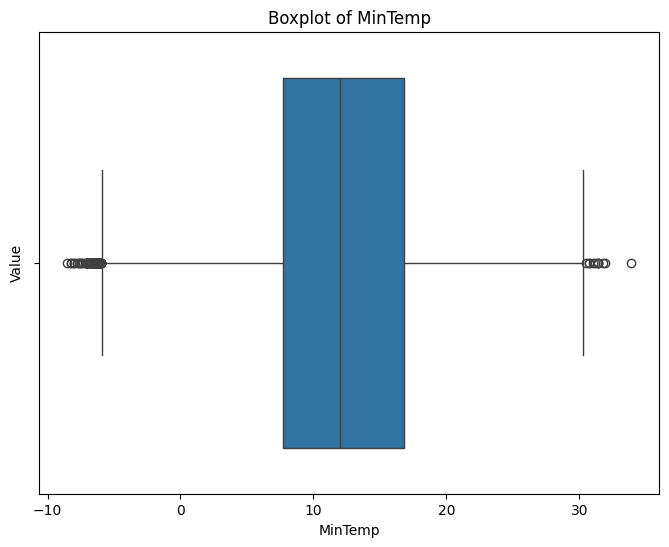

<Figure size 640x480 with 0 Axes>

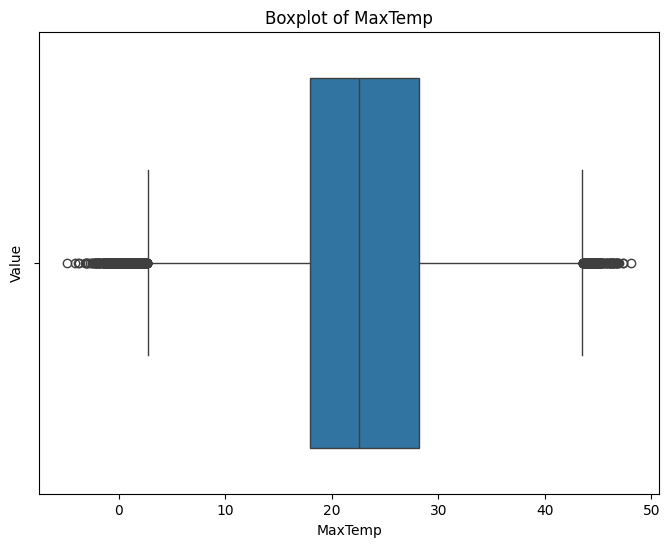

<Figure size 640x480 with 0 Axes>

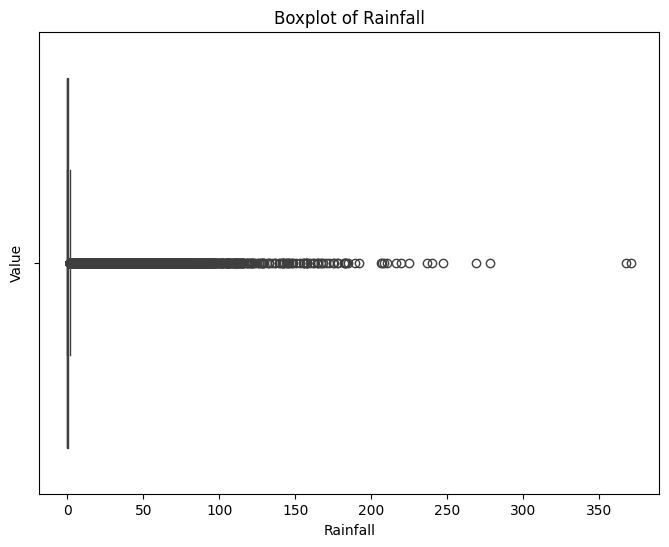

<Figure size 640x480 with 0 Axes>

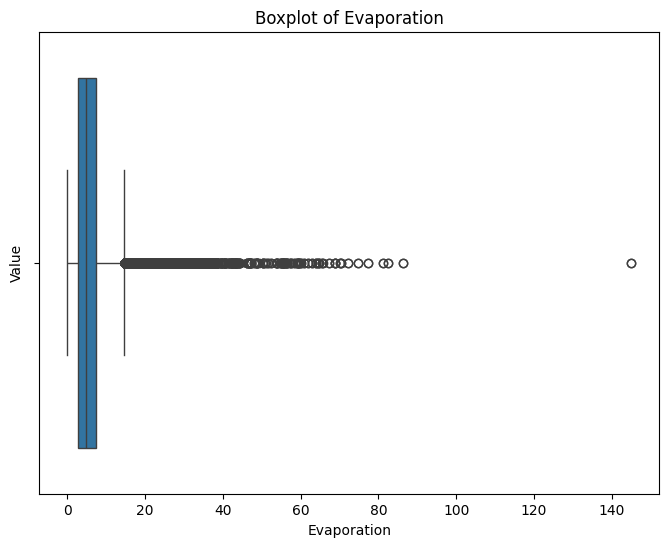

<Figure size 640x480 with 0 Axes>

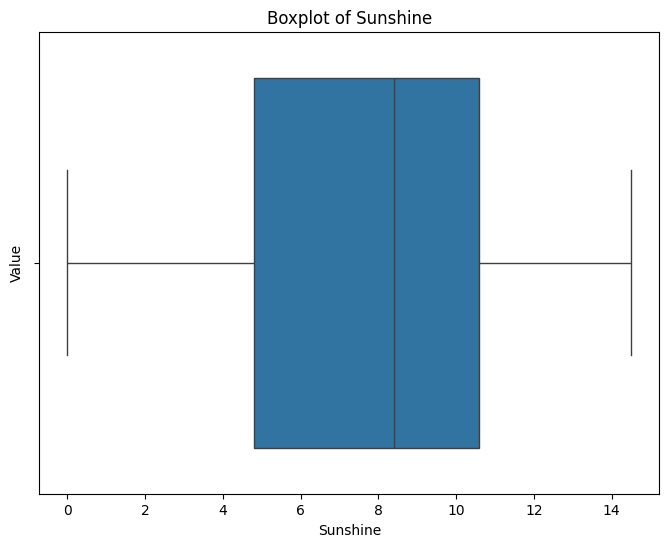

<Figure size 640x480 with 0 Axes>

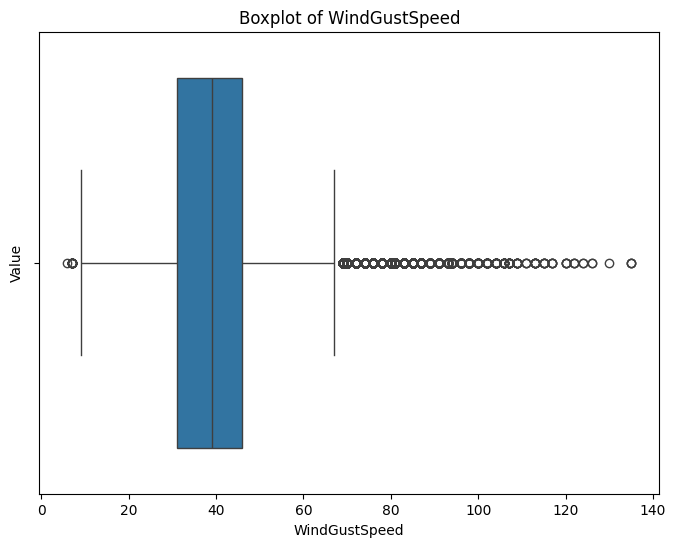

<Figure size 640x480 with 0 Axes>

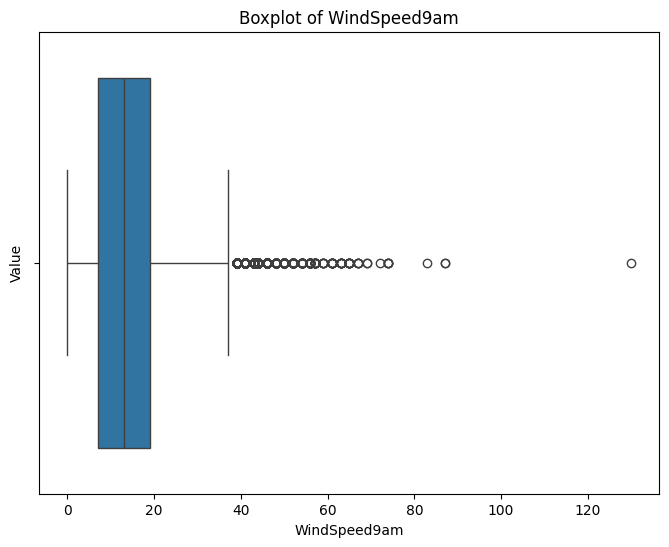

<Figure size 640x480 with 0 Axes>

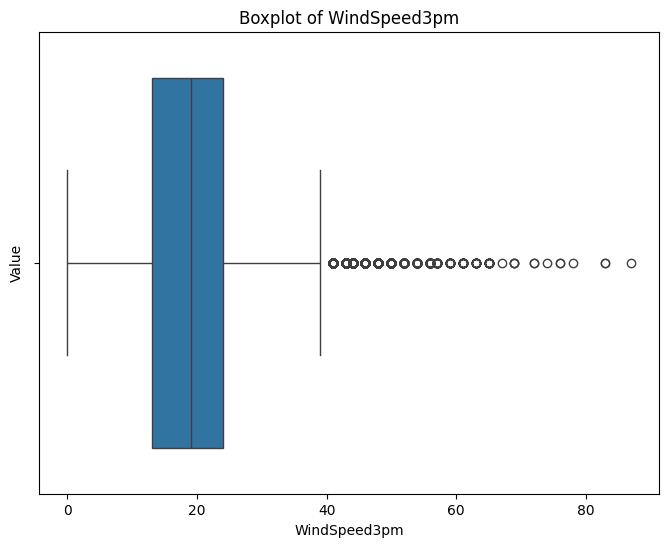

<Figure size 640x480 with 0 Axes>

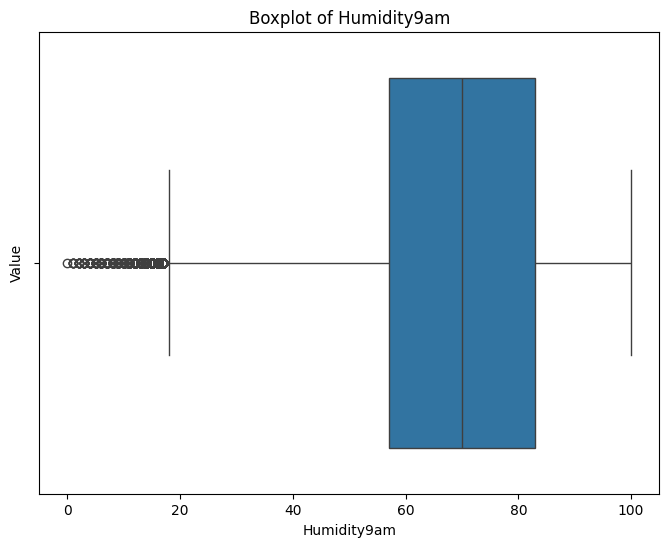

<Figure size 640x480 with 0 Axes>

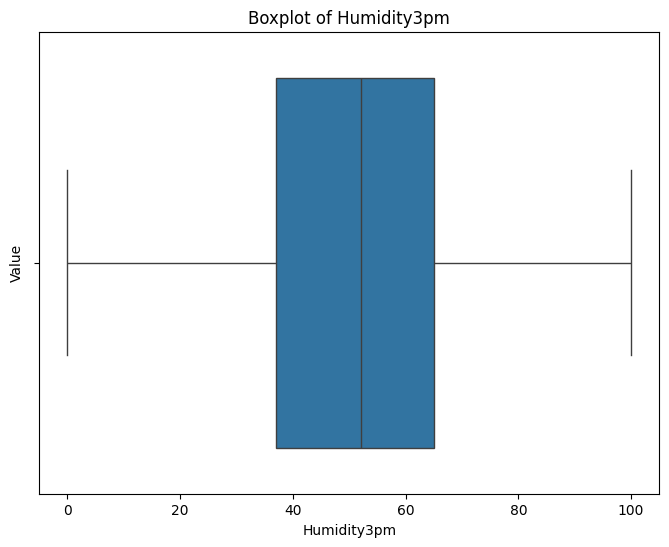

<Figure size 640x480 with 0 Axes>

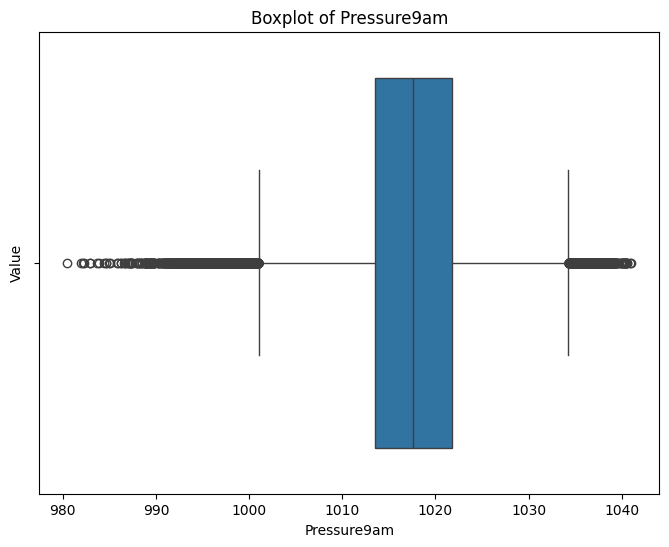

<Figure size 640x480 with 0 Axes>

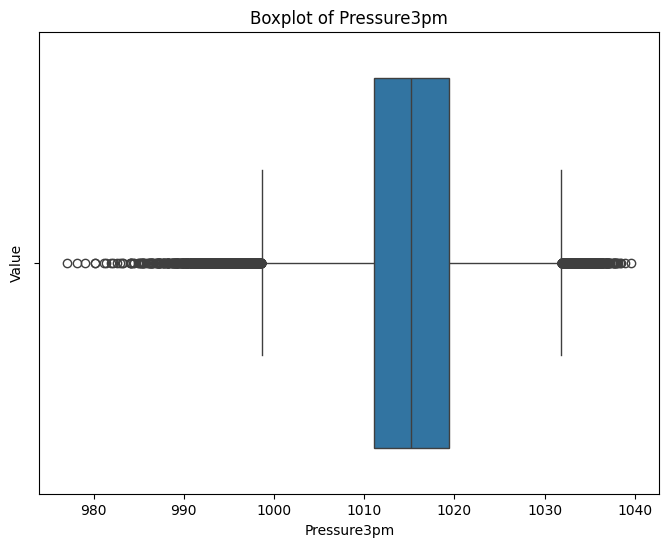

<Figure size 640x480 with 0 Axes>

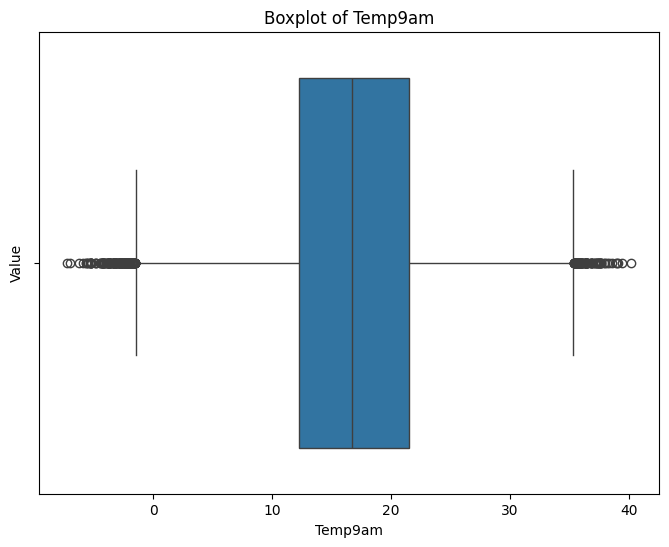

<Figure size 640x480 with 0 Axes>

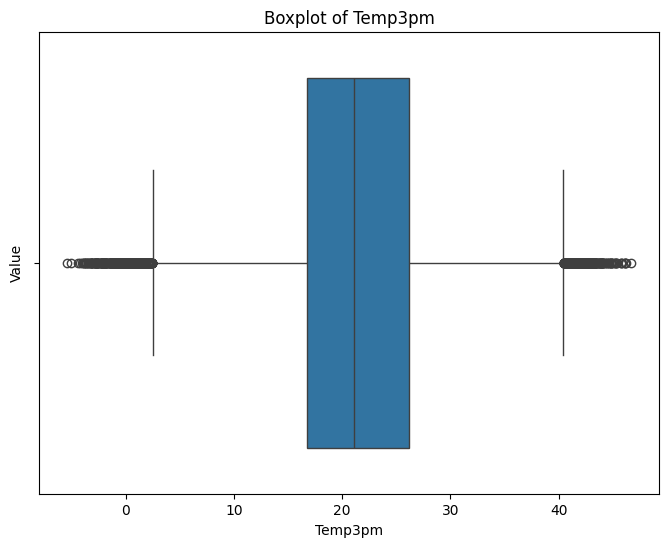

<Figure size 640x480 with 0 Axes>

In [29]:
for feature in continuous_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x = dataset[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Value')
    plt.show()
    plt.tight_layout()

## Calculating inter-quantile range to remove outliers

### MinTemp

In [30]:
IQR_MinTemp = dataset.MinTemp.quantile(0.75) - dataset.MinTemp.quantile(0.25)
lower_IQR_MinTemp = dataset.MinTemp.quantile(0.25) - (IQR_MinTemp * 1.5)
upper_IQR_MinTemp = dataset.MinTemp.quantile(0.75) + (IQR_MinTemp * 1.5)
print(lower_IQR_MinTemp, upper_IQR_MinTemp)

-5.950000000000002 30.450000000000003


In [31]:
dataset.loc[dataset['MinTemp'] >= 30.45, 'MinTemp'] = 30.45
dataset.loc[dataset['MinTemp'] <= -5.95, 'MinTemp'] = -5.95

### MaxTemp

In [32]:
IQR_MaxTemp = dataset.MaxTemp.quantile(0.75) - dataset.MaxTemp.quantile(0.25)
lower_IQR_MaxTemp = dataset.MaxTemp.quantile(0.25) - (IQR_MaxTemp * 1.5)
upper_IQR_MaxTemp = dataset.MaxTemp.quantile(0.75) + (IQR_MaxTemp * 1.5)
print(lower_IQR_MaxTemp, upper_IQR_MaxTemp)

2.700000000000001 43.5


In [33]:
dataset.loc[dataset['MaxTemp'] >= 43.5, 'MaxTemp'] = 43.5
dataset.loc[dataset['MaxTemp'] <= 2.7, 'MaxTemp'] = 2.7

### Rainfall

In [34]:
IQR_Rainfall = dataset.Rainfall.quantile(0.75) - dataset.Rainfall.quantile(0.25)
lower_IQR_Rainfall = dataset.Rainfall.quantile(0.25) - (IQR_Rainfall * 1.5)
upper_IQR_Rainfall = dataset.Rainfall.quantile(0.75) + (IQR_Rainfall * 1.5)
print(lower_IQR_Rainfall, upper_IQR_Rainfall)

-0.8999999999999999 1.5


In [35]:
dataset.loc[dataset['Rainfall'] >= 1.5, 'Rainfall'] = 1.5
dataset.loc[dataset['Rainfall'] <= -0.89, 'Rainfall'] = -0.89

### Evaporation

In [36]:
IQR_Evap = dataset.Evaporation.quantile(0.75) - dataset.Evaporation.quantile(0.25)
lower_IQR_Evap = dataset.Evaporation.quantile(0.25) - (IQR_Evap * 1.5)
upper_IQR_Evap = dataset.Evaporation.quantile(0.75) + (IQR_Evap * 1.5)
print(lower_IQR_Evap, upper_IQR_Evap)

-4.600000000000001 14.600000000000001


In [37]:

dataset.loc[dataset['Evaporation'] >= 14.6, 'Evaporation'] = 14.6
dataset.loc[dataset['Evaporation'] <= -4.6, 'Evaporation'] = -4.6

### WindGustSpeed

In [38]:
IQR_WGS = dataset.WindGustSpeed.quantile(0.75) - dataset.WindGustSpeed.quantile(0.25)
lower_IQR_WGS = dataset.WindGustSpeed.quantile(0.25) - (IQR_WGS * 1.5)
upper_IQR_WGS = dataset.WindGustSpeed.quantile(0.75) + (IQR_WGS * 1.5)
print(lower_IQR_WGS, upper_IQR_WGS)

8.5 68.5


In [39]:
dataset.loc[dataset['WindGustSpeed'] >= 68.5, 'WindGustSpeed'] = 68.5
dataset.loc[dataset['WindGustSpeed'] <= 8.5, 'WindGustSpeed'] = 8.5

### WindSpeed9am 

In [40]:
IQR_WS9 = dataset.WindSpeed9am.quantile(0.75) - dataset.WindSpeed9am.quantile(0.25)
lower_IQR_WS9 = dataset.WindSpeed9am.quantile(0.25) - (IQR_WS9 * 1.5)
upper_IQR_WS9 = dataset.WindSpeed9am.quantile(0.75) + (IQR_WS9 * 1.5)
print(lower_IQR_WS9, upper_IQR_WS9)

-11.0 37.0


In [41]:
dataset.loc[dataset['WindSpeed9am'] >= 37, 'WindSpeed9am'] = 37
dataset.loc[dataset['WindSpeed9am'] <= -11, 'WindSpeed9am'] = -11

### WindSpeed3pm 

In [42]:
IQR_WS3 = dataset.WindSpeed3pm.quantile(0.75) - dataset.WindSpeed3pm.quantile(0.25)
lower_IQR_WS3 = dataset.WindSpeed3pm.quantile(0.25)-(IQR_WS3 * 1.5)
upper_IQR_WS3 = dataset.WindSpeed3pm.quantile(0.75)+(IQR_WS3 * 1.5)
print(lower_IQR_WS3, upper_IQR_WS3)

-3.5 40.5


In [43]:
dataset.loc[dataset['WindSpeed3pm'] > 40.5, 'WindSpeed3pm'] = 40.5
dataset.loc[dataset['WindSpeed3pm'] <= -3.5, 'WindSpeed3pm'] = -3.5

### Humidity9am 

In [44]:
IQR_H9 = dataset.Humidity9am.quantile(0.75) - dataset.Humidity9am.quantile(0.25)
lower_IQR_H9 = dataset.Humidity9am.quantile(0.25) - (IQR_H9 * 1.5)
upper_IQR_H9 = dataset.Humidity9am.quantile(0.75) + (IQR_H9 * 1.5)
print(lower_IQR_H9, upper_IQR_H9)

18.0 122.0


In [45]:
dataset.loc[dataset['Humidity9am'] >= 122, 'Humidity9am'] = 122
dataset.loc[dataset['Humidity9am'] <= 18, 'Humidity9am'] = 18

### Pressure9am

In [46]:
IQR_P9 = dataset.Pressure9am.quantile(0.75) - dataset.Pressure9am.quantile(0.25)
lower_IQR_P9 = dataset.Pressure9am.quantile(0.25) - (IQR_P9 * 1.5)
upper_IQR_P9 = dataset.Pressure9am.quantile(0.75) + (IQR_P9 * 1.5)
print(lower_IQR_P9, upper_IQR_P9)

1001.0500000000001 1034.25


In [47]:
dataset.loc[dataset['Pressure9am'] >= 1034.25, 'Pressure9am'] = 1034.25
dataset.loc[dataset['Pressure9am'] <= 1001.05, 'Pressure9am'] = 1001.05

### Pressure3pm

In [48]:
IQR_P3 = dataset.Pressure3pm.quantile(0.75) - dataset.Pressure3pm.quantile(0.25)
lower_IQR_P3 = dataset.Pressure3pm.quantile(0.25) - (IQR_P3 * 1.5)
upper_IQR_P3 = dataset.Pressure3pm.quantile(0.75) + (IQR_P3 * 1.5)
print(lower_IQR_P3, upper_IQR_P3)

998.6500000000001 1031.85


In [49]:
dataset.loc[dataset['Pressure3pm'] >= 1031.85, 'Pressure3pm'] = 1031.85
dataset.loc[dataset['Pressure3pm'] <= 998.65, 'Pressure3pm'] = 998.65

### Temp9am 

In [50]:
IQR_T9 = dataset.Temp9am.quantile(0.75) - dataset.Temp9am.quantile(0.25)
lower_IQR_T9 = dataset.Temp9am.quantile(0.25) - (IQR_T9 * 1.5)
upper_IQR_T9 = dataset.Temp9am.quantile(0.75) + (IQR_T9 * 1.5)
print(lower_IQR_T9, upper_IQR_T9)

-1.4999999999999982 35.3


In [51]:
dataset.loc[dataset['Temp9am'] >= 35.3, 'Temp9am'] = 35.3
dataset.loc[dataset['Temp9am'] <= -1.49, 'Temp9am'] = -1.49

### Temp3pm

In [52]:
IQR_T3 = dataset.Temp3pm.quantile(0.75) - dataset.Temp3pm.quantile(0.25)
lower_IQR_T3 = dataset.Temp3pm.quantile(0.25) - (IQR_T3 * 1.5)
upper_IQR_T3 = dataset.Temp3pm.quantile(0.75) + (IQR_T3 * 1.5)
print(lower_IQR_T3, upper_IQR_T3)

2.4499999999999993 40.45


In [53]:
dataset.loc[dataset['Temp3pm'] >= 40.45, 'Temp3pm'] = 40.45
dataset.loc[dataset['Temp3pm'] <= 2.45, 'Temp3pm'] = 2.45

## Plotting boxplots of continuous features to check for outliers again

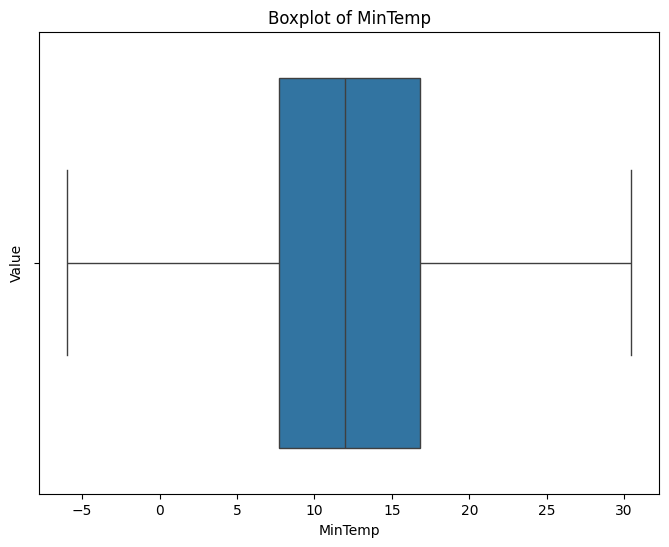

<Figure size 640x480 with 0 Axes>

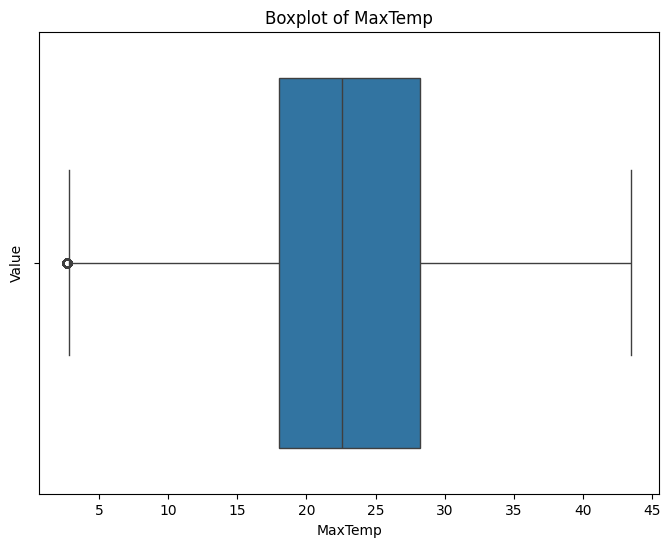

<Figure size 640x480 with 0 Axes>

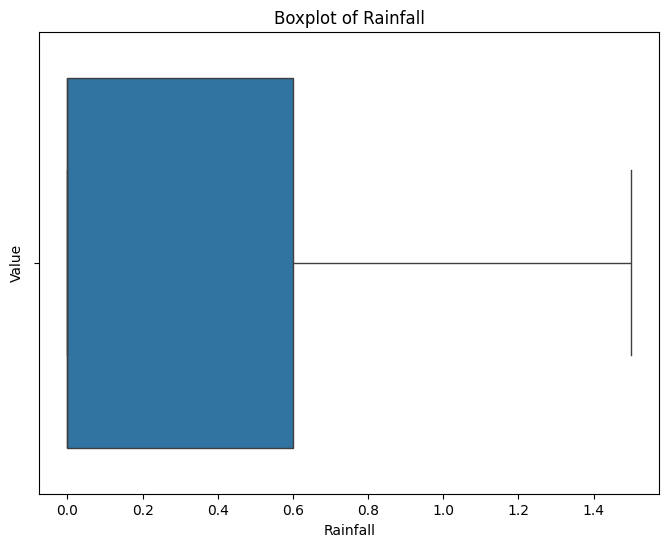

<Figure size 640x480 with 0 Axes>

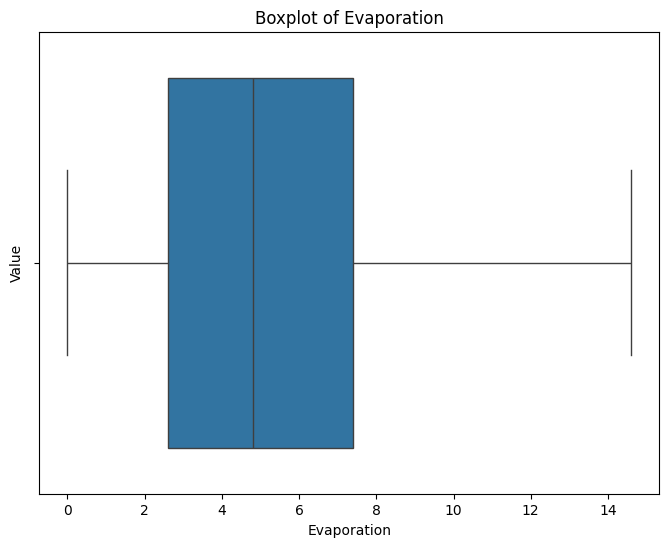

<Figure size 640x480 with 0 Axes>

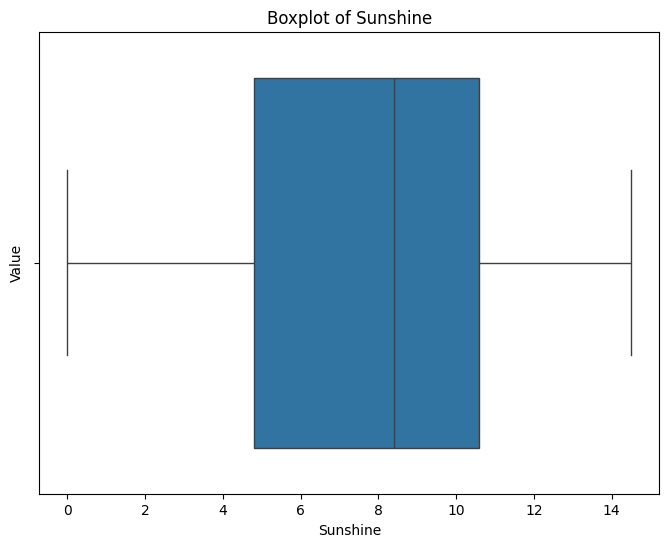

<Figure size 640x480 with 0 Axes>

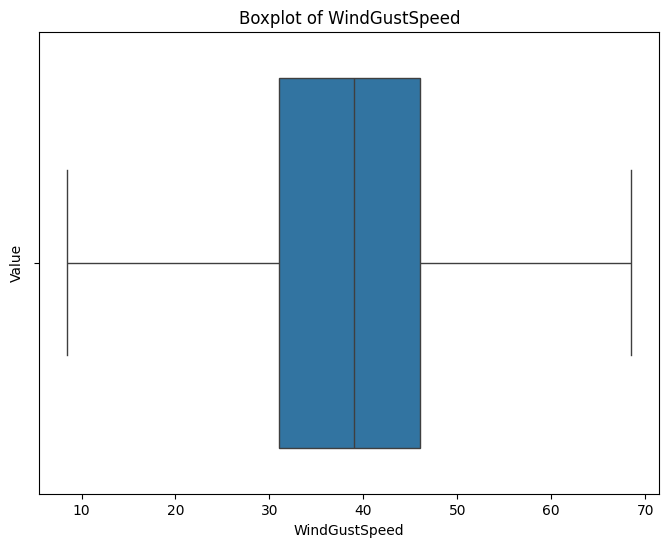

<Figure size 640x480 with 0 Axes>

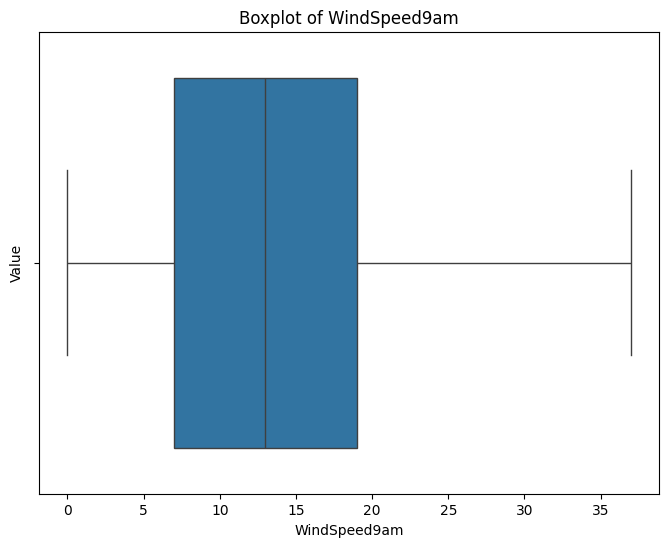

<Figure size 640x480 with 0 Axes>

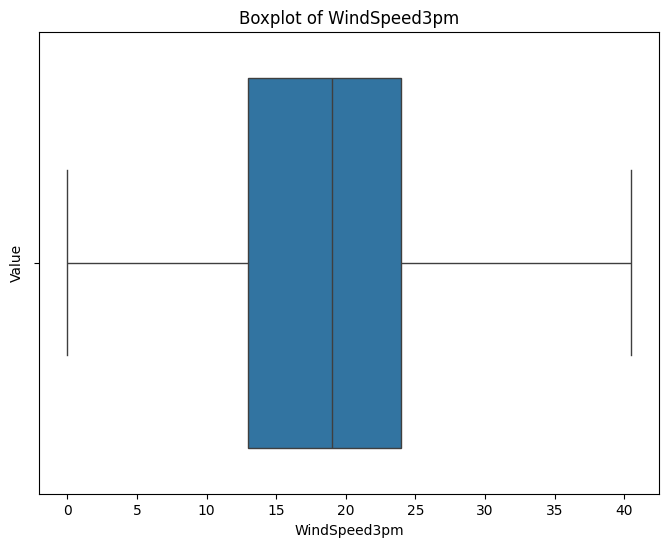

<Figure size 640x480 with 0 Axes>

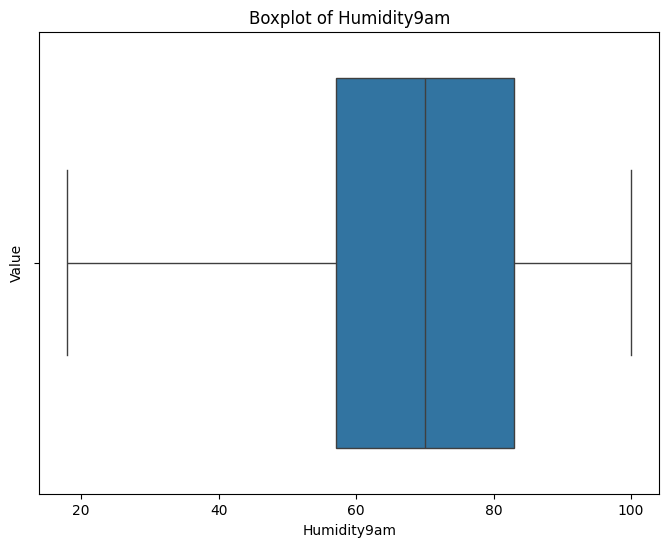

<Figure size 640x480 with 0 Axes>

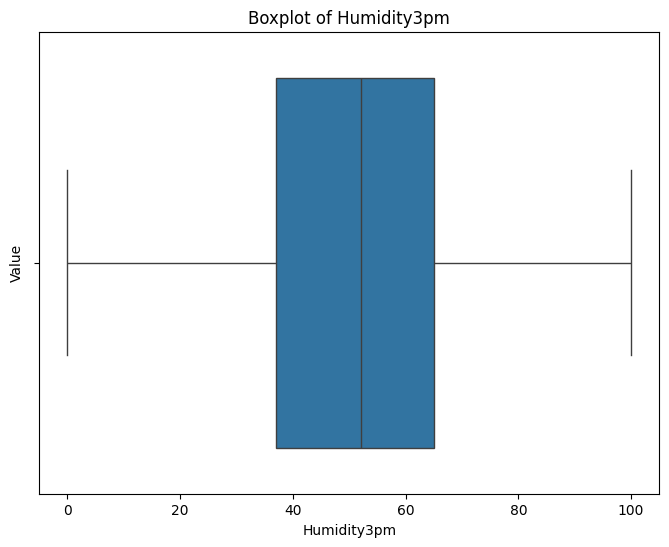

<Figure size 640x480 with 0 Axes>

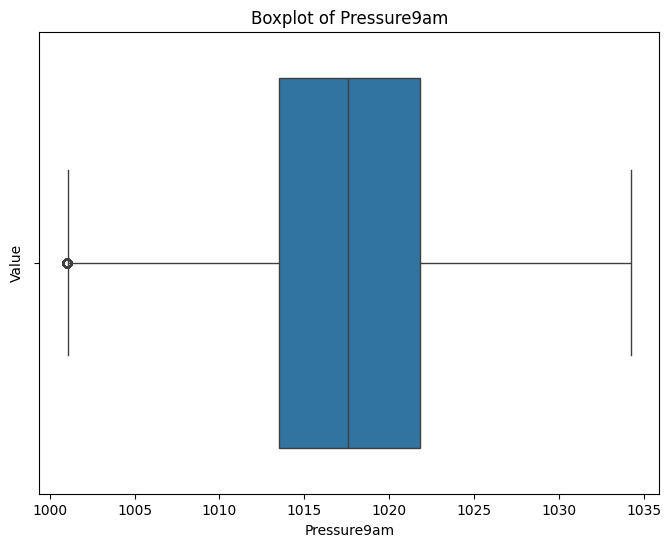

<Figure size 640x480 with 0 Axes>

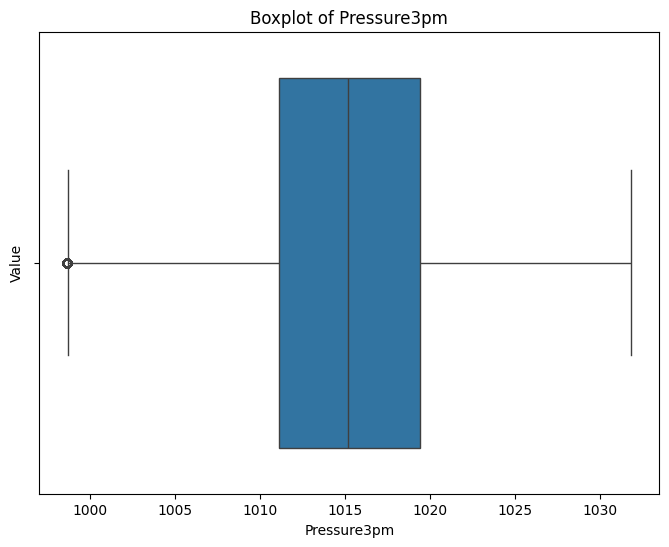

<Figure size 640x480 with 0 Axes>

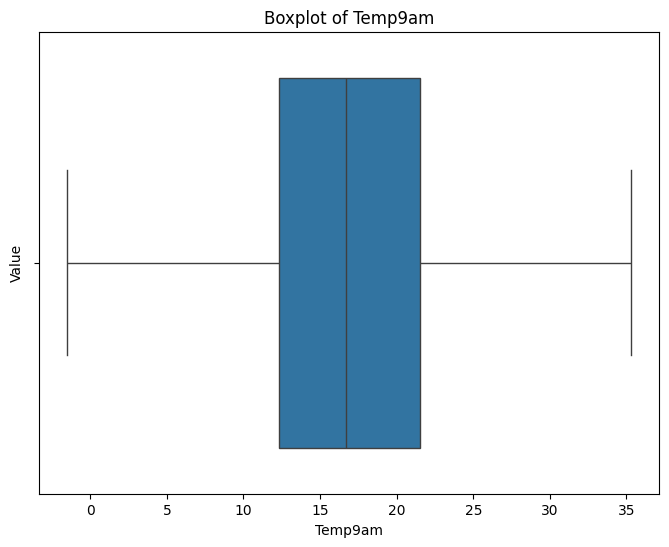

<Figure size 640x480 with 0 Axes>

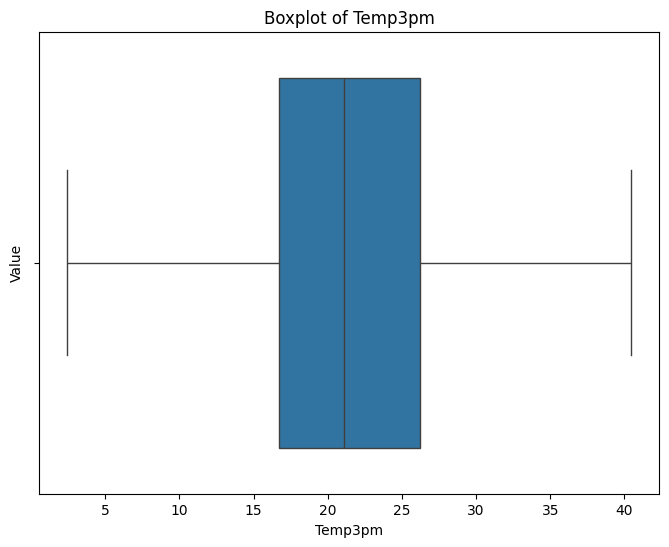

<Figure size 640x480 with 0 Axes>

In [54]:
for feature in continuous_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x = dataset[feature])
    plt.title(f'Boxplot of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Value')
    plt.show()
    plt.tight_layout()

## Saving preprocessed dataset to csv

In [59]:
dataset.to_csv("preprocessed_weatherAUS.csv", index = False)

## Splitting the dataset into X and y

In [59]:
X = dataset.drop(["RainTomorrow", "Date"], axis=1)
y = dataset["RainTomorrow"]

## Splitting the dataset into training and test set

In [60]:
# stratify helps us to ensure that class proportions in 'y' are maintained in both training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 0)

In [62]:
print(f'Shape of training and test sets:\nX_train = {X_train.shape}\nX_test = {X_test.shape}\ny_train = {y_train.shape}\ny_test = {y_test.shape}')

Shape of training and test sets:
X_train = (116368, 23)
X_test = (29092, 23)
y_train = (116368,)
y_test = (29092,)


## Applying SMOTE to address class imbalance

In [63]:
sm = SMOTE(random_state = 0)
X_train_, y_train_ = sm.fit_resample(X_train, y_train)
print("Number of classes before fit {}".format(Counter(y_train)))
print("Number of classes after fit {}".format(Counter(y_train_)))

Number of classes before fit Counter({False: 90866, True: 25502})
Number of classes after fit Counter({False: 90866, True: 90866})


# Fitting different models

## Logistic Regression

In [64]:
classifier_lr = LogisticRegression(random_state = 0)
classifier_lr.fit(X_train_, y_train_)

c:\Users\jamal\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=0)

In [65]:
y_pred1 = classifier_lr.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred1))

accuracy1 = accuracy_score(y_test, y_pred1)
print(f'\nAccuracy = {accuracy1 * 100 :.2f}%')

print("\nClassification Report:")
print(classification_report(y_test, y_pred1))

Confusion Matrix:
[[17539  5178]
 [ 1517  4858]]

Accuracy = 76.99%

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.77      0.84     22717
        True       0.48      0.76      0.59      6375

    accuracy                           0.77     29092
   macro avg       0.70      0.77      0.72     29092
weighted avg       0.82      0.77      0.79     29092



## KNN Classifier

In [66]:
classifier_knn_5 = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier_knn_5.fit(X_train_, y_train_)

KNeighborsClassifier()

In [67]:
y_pred2 = classifier_knn_5.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred2))

accuracy2 = accuracy_score(y_test, y_pred2)
print(f'\nAccuracy = {accuracy2 * 100 :.2f}%')

print("\nClassification Report:")
print(classification_report(y_test, y_pred2))

Confusion Matrix:
[[16818  5899]
 [ 1561  4814]]

Accuracy = 74.36%

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.74      0.82     22717
        True       0.45      0.76      0.56      6375

    accuracy                           0.74     29092
   macro avg       0.68      0.75      0.69     29092
weighted avg       0.81      0.74      0.76     29092



In [68]:
classifier_knn_4 = KNeighborsClassifier(n_neighbors = 4, metric = 'minkowski', p = 2)
classifier_knn_4.fit(X_train_, y_train_)

KNeighborsClassifier(n_neighbors=4)

In [69]:
y_pred22 = classifier_knn_4.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred22))

accuracy22 = accuracy_score(y_test, y_pred22)
print(f'\nAccuracy = {accuracy22 * 100 :.2f}%')

print("\nClassification Report:")
print(classification_report(y_test, y_pred22))

Confusion Matrix:
[[18356  4361]
 [ 2102  4273]]

Accuracy = 77.78%

Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.81      0.85     22717
        True       0.49      0.67      0.57      6375

    accuracy                           0.78     29092
   macro avg       0.70      0.74      0.71     29092
weighted avg       0.81      0.78      0.79     29092



In [70]:
classifier_knn_3 = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2)
classifier_knn_3.fit(X_train_, y_train_)

KNeighborsClassifier(n_neighbors=3)

In [71]:
y_pred222 = classifier_knn_3.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred222))

accuracy222 = accuracy_score(y_test, y_pred222)
print(f'\nAccuracy = {accuracy222 * 100 :.2f}%')

print("\nClassification Report:")
print(classification_report(y_test, y_pred222))

Confusion Matrix:
[[17312  5405]
 [ 1778  4597]]

Accuracy = 75.31%

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.76      0.83     22717
        True       0.46      0.72      0.56      6375

    accuracy                           0.75     29092
   macro avg       0.68      0.74      0.69     29092
weighted avg       0.81      0.75      0.77     29092



## SVM (linear)



took 1 hour but nothing . . . 

In [72]:
# classifier_svc_lin = SVC(kernel = 'linear', random_state = 0)
# classifier_svc_lin.fit(X_train_, y_train_)

In [73]:
# y_pred3 = classifier_svc_lin.predict(X_test)

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred3))

# accuracy3 = accuracy_score(y_test, y_pred3)
# print(f'\nAccuracy = {accuracy3 * 100 :.2f}%')

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred3))

In [74]:
# svc = SVC()
# svc.fit(X_train_, y_train_)

# y_pred33 = svc.predict(X_test)
# print(confusion_matrix(y_test,y_pred33))
# print(accuracy_score(y_test,y_pred33))
# print(classification_report(y_test,y_pred33))

## SVM (non-linear)

In [75]:
classifier_svc_rbf = SVC(kernel = 'rbf', random_state = 0)
classifier_svc_rbf.fit(X_train_, y_train_)

SVC(random_state=0)

In [76]:
y_pred4 = classifier_svc_rbf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred4))

accuracy4 = accuracy_score(y_test, y_pred4)
print(f'\nAccuracy = {accuracy4 * 100 :.2f}%')

print("\nClassification Report:")
print(classification_report(y_test, y_pred4))

Confusion Matrix:
[[17834  4883]
 [ 1598  4777]]

Accuracy = 77.72%

Classification Report:
              precision    recall  f1-score   support

       False       0.92      0.79      0.85     22717
        True       0.49      0.75      0.60      6375

    accuracy                           0.78     29092
   macro avg       0.71      0.77      0.72     29092
weighted avg       0.83      0.78      0.79     29092



## Naive Bayes Classifier

In [77]:
classifier_gnb = GaussianNB()
classifier_gnb.fit(X_train_, y_train_)

GaussianNB()

In [78]:
y_pred5 = classifier_gnb.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred5))

accuracy5 = accuracy_score(y_test, y_pred5)
print(f'\nAccuracy = {accuracy5 * 100 :.2f}%')

print("\nClassification Report:")
print(classification_report(y_test, y_pred5))

Confusion Matrix:
[[17478  5239]
 [ 1825  4550]]

Accuracy = 75.72%

Classification Report:
              precision    recall  f1-score   support

       False       0.91      0.77      0.83     22717
        True       0.46      0.71      0.56      6375

    accuracy                           0.76     29092
   macro avg       0.69      0.74      0.70     29092
weighted avg       0.81      0.76      0.77     29092



## Random Forest Classifier

In [91]:
classifier_rf = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier_rf.fit(X_train_, y_train_)

RandomForestClassifier(criterion='entropy', random_state=0)

In [92]:
y_pred6 = classifier_rf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred6))

accuracy6 = accuracy_score(y_test, y_pred6)
print(f'\nAccuracy = {accuracy6 * 100 :.2f}%')

print("\nClassification Report:")
print(classification_report(y_test, y_pred6))

Confusion Matrix:
[[20862  1855]
 [ 2555  3820]]

Accuracy = 84.84%

Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.92      0.90     22717
        True       0.67      0.60      0.63      6375

    accuracy                           0.85     29092
   macro avg       0.78      0.76      0.77     29092
weighted avg       0.84      0.85      0.85     29092



## XGBoost Classifier

In [82]:
xgboost = XGBClassifier()
xgboost.fit(X_train_, y_train_)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [83]:
y_pred7 = xgboost.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred7))

accuracy7 = accuracy_score(y_test, y_pred7)
print(f'\nAccuracy = {accuracy7 * 100 :.2f}%')

print("\nClassification Report:")
print(classification_report(y_test, y_pred7))

Confusion Matrix:
[[21403  1314]
 [ 2854  3521]]

Accuracy = 85.67%

Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.94      0.91     22717
        True       0.73      0.55      0.63      6375

    accuracy                           0.86     29092
   macro avg       0.81      0.75      0.77     29092
weighted avg       0.85      0.86      0.85     29092



## Catboost Classifier

In [84]:
catboost = CatBoostClassifier(iterations = 2000, eval_metric = "AUC")
catboost.fit(X_train_, y_train_)

Learning rate set to 0.050311
0:	total: 238ms	remaining: 7m 55s
1:	total: 314ms	remaining: 5m 13s
2:	total: 372ms	remaining: 4m 7s
3:	total: 459ms	remaining: 3m 48s
4:	total: 534ms	remaining: 3m 33s
5:	total: 603ms	remaining: 3m 20s
6:	total: 677ms	remaining: 3m 12s
7:	total: 742ms	remaining: 3m 4s
8:	total: 806ms	remaining: 2m 58s
9:	total: 864ms	remaining: 2m 51s
10:	total: 940ms	remaining: 2m 50s
11:	total: 1s	remaining: 2m 46s
12:	total: 1.07s	remaining: 2m 43s
13:	total: 1.13s	remaining: 2m 40s
14:	total: 1.22s	remaining: 2m 41s
15:	total: 1.28s	remaining: 2m 39s
16:	total: 1.36s	remaining: 2m 38s
17:	total: 1.42s	remaining: 2m 36s
18:	total: 1.48s	remaining: 2m 34s
19:	total: 1.55s	remaining: 2m 33s
20:	total: 1.61s	remaining: 2m 31s
21:	total: 1.67s	remaining: 2m 29s
22:	total: 1.74s	remaining: 2m 29s
23:	total: 1.79s	remaining: 2m 27s
24:	total: 1.85s	remaining: 2m 26s
25:	total: 1.92s	remaining: 2m 25s
26:	total: 1.98s	remaining: 2m 24s
27:	total: 2.04s	remaining: 2m 23s
28:	t

In [93]:
# y_pred8 = catboost.predict(X_test)

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred8))

# accuracy8 = accuracy_score(y_test, y_pred8)
# print(f'\nAccuracy = {accuracy8 * 100 :.2f}%')

# print("\nClassification Report:")
# print(classification_report(y_test, y_pred8))

In [88]:
y_pred_proba = catboost.predict_proba(X_test)

y_pred_proba_pos = y_pred_proba[:, 1]

threshold = 0.5

y_pred88 = (y_pred_proba_pos >= threshold).astype(int)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred88))

accuracy88 = accuracy_score(y_test, y_pred88)
print(f'\nAccuracy = {accuracy88 * 100 :.2f}%')

print("\nClassification Report:")
print(classification_report(y_test, y_pred88))

Confusion Matrix:
[[21502  1215]
 [ 2802  3573]]

Accuracy = 86.19%

Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.95      0.91     22717
        True       0.75      0.56      0.64      6375

    accuracy                           0.86     29092
   macro avg       0.82      0.75      0.78     29092
weighted avg       0.85      0.86      0.85     29092



# Saving the models

In [94]:
joblib.dump(classifier_lr, "classifier_lr.pkl") # Accuracy = 76.99%
joblib.dump(classifier_knn_5, "classifier_knn_5.pkl") # Accuracy = 74.36%
joblib.dump(classifier_knn_4, "classifier_knn_4.pkl") # Accuracy = 77.78%
joblib.dump(classifier_knn_3, "classifier_knn_3.pkl") # Accuracy = 75.31%
joblib.dump(classifier_svc_rbf, "classifier_svc_rbf.pkl") # Accuracy = 77.72%
joblib.dump(classifier_gnb, "classifier_gnb.pkl") # Accuracy = 75.72%
joblib.dump(classifier_rf, "classifier_rf.pkl") # Accuracy = 84.84%
joblib.dump(xgboost, "xgboost.pkl") # Accuracy = 85.67%
joblib.dump(catboost, "catboost.pkl") # Accuracy = 86.19%

['catboost.pkl']

# Checking manually model prediction

In [1]:
import pickle

In [3]:
model = pickle.load(open("catboost.pkl", "rb"))

In [8]:
df = pd.read_csv('preprocessed_weatherAUS.csv')

In [9]:
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'Date_month', 'Date_day'],
      dtype='object')

In [13]:
df.dtypes

Date              object
Location           int64
MinTemp          float64
MaxTemp          float64
Rainfall         float64
Evaporation      float64
Sunshine         float64
WindGustDir      float64
WindGustSpeed    float64
WindDir9am       float64
WindDir3pm       float64
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Cloud9am         float64
Cloud3pm         float64
Temp9am          float64
Temp3pm          float64
RainToday           bool
RainTomorrow        bool
Date_month         int64
Date_day           int64
dtype: object

In [14]:
df['RainToday']

0         False
1         False
2         False
3         False
4         False
          ...  
145455    False
145456    False
145457    False
145458    False
145459    False
Name: RainToday, Length: 145460, dtype: bool

In [ ]:
# Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
#        'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
#        'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
#        'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
#        'Temp3pm', 'RainToday', 'Date_month', 'Date_day'],

In [ ]:
windgustdir = {'NNW':0, 'NW':1, 'WNW':2, 'N':3, 'W':4, 'WSW':5, 'NNE':6, 'S':7, 'SSW':8, 'SW':9, 'SSE':10,
               'NE':11, 'SE':12, 'ESE':13, 'ENE':14, 'E':15}
winddir9am = {'NNW':0, 'N':1, 'NW':2, 'NNE':3, 'WNW':4, 'W':5, 'WSW':6, 'SW':7, 'SSW':8, 'NE':9, 'S':10,
              'SSE':11, 'ENE':12, 'SE':13, 'ESE':14, 'E':15}
winddir3pm = {'NW':0, 'NNW':1, 'N':2, 'WNW':3, 'W':4, 'NNE':5, 'WSW':6, 'SSW':7, 'S':8, 'SW':9, 'SE':10,
               'NE':11, 'SSE':12, 'ENE':13, 'E':14, 'ESE':15}

In [17]:
inputs = [30, 13.4, 22.9, 0.6, 2.4, 8.3, 
          4.0, 44, 5.0, 0.0, 
          20, 24, 
          71, 22, 
          1007.7, 1007.1, 
          8, 0, 
          16.9, 21.8,
          0.0, 9, 12]

In [18]:
pred = model.predict(inputs)

In [19]:
print(pred)

False


In [ ]:
# input_lst = [location , minTemp , maxTemp , rainfall , evaporation , sunshine ,
# windGustDir , windGustSpeed , winddDir9am , winddDir3pm , 
# windSpeed9am , windSpeed3pm ,
# humidity9am , humidity3pm , 
# pressure9am , pressure3pm , 
# cloud9am , cloud3pm , 
# temp9am , temp3pm ,
# rainToday , month , day]

In [ ]:
location = {'Portland':1, 'Cairns':2, 'Walpole':3, 'Dartmoor':4, 'MountGambier':5,
       'NorfolkIsland':6, 'Albany':7, 'Witchcliffe':8, 'CoffsHarbour':9, 'Sydney':10,
       'Darwin':11, 'MountGinini':12, 'NorahHead':13, 'Ballarat':14, 'GoldCoast':15,
       'SydneyAirport':16, 'Hobart':17, 'Watsonia':18, 'Newcastle':19, 'Wollongong':20,
       'Brisbane':21, 'Williamtown':22, 'Launceston':23, 'Adelaide':24, 'MelbourneAirport':25,
       'Perth':26, 'Sale':27, 'Melbourne':28, 'Canberra':29, 'Albury':30, 'Penrith':31,
       'Nuriootpa':32, 'BadgerysCreek':33, 'Tuggeranong':34, 'PerthAirport':35, 'Bendigo':36,
       'Richmond':37, 'WaggaWagga':38, 'Townsville':39, 'PearceRAAF':40, 'SalmonGums':41,
       'Moree':42, 'Cobar':43, 'Mildura':44, 'Katherine':45, 'AliceSprings':46, 'Nhil':47,
       'Woomera':48, 'Uluru':49}

Albury = 30